In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
!ls "/gdrive/My Drive/Frame_prediction_kitti/Train/"

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
0000000000.png	0000000006.png	0000000012.png	0000000018.png	0000000024.png
0000000001.png	0000000007.png	0000000013.png	0000000019.png	0000000025.png
0000000002.png	0000000008.png	0000000014.png	0000000020.png	0000000026.png
0000000003.png	0000000009.png	0000000015.png	0000000021.png	0000000027.png
0000000004.png	0000000010.png	0000000016.png	0000000022.png
0000000005.png	0000000011.png	0000000017.png	0000000023.png


In [ ]:
%tensorflow_version 1.x

In [ ]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import BatchNormalization, Reshape, Dense, Input, LeakyReLU, Conv2D, Conv2DTranspose, Concatenate, ReLU, Dropout, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Input, BatchNormalization, Dense
from keras.layers.core import RepeatVector, Permute
from scipy import ndimage, misc
from keras.optimizers import Adam
from keras.layers import  Flatten,Dense
from keras.initializers import RandomNormal
from keras.layers import LeakyReLU
import random
from keras.layers import Concatenate
from keras.models import load_model

from keras.layers import  Flatten,Dense
from keras.layers import Activation

In [ ]:
X = []
names = os.listdir('/gdrive/My Drive/Frame_prediction_kitti/Train/')
names.sort()
print(names)
for filename in names:
    #print(filename)
    img = cv2.imread('/gdrive/My Drive/Frame_prediction_kitti/Train/'+filename, cv2.IMREAD_UNCHANGED)
    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * (scale_percent-6)/ 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (256, 256)
    #print(dim)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
   # plt.imshow(img)
    X.append(resized)
    #plt.show()

X = np.array(X, dtype=float)
print("##################")
# for ele in X:
#   plt.imshow(ele)
#   plt.show()
Xtrain = 1.0/255*X
Xtrain.shape

['0000000000.png', '0000000001.png', '0000000002.png', '0000000003.png', '0000000004.png', '0000000005.png', '0000000006.png', '0000000007.png', '0000000008.png', '0000000009.png', '0000000010.png', '0000000011.png', '0000000012.png', '0000000013.png', '0000000014.png', '0000000015.png', '0000000016.png', '0000000017.png', '0000000018.png', '0000000019.png', '0000000020.png', '0000000021.png', '0000000022.png', '0000000023.png', '0000000024.png', '0000000025.png', '0000000026.png', '0000000027.png']
##################


(28, 256, 256)

(28, 256, 256, 1)
1.15.2


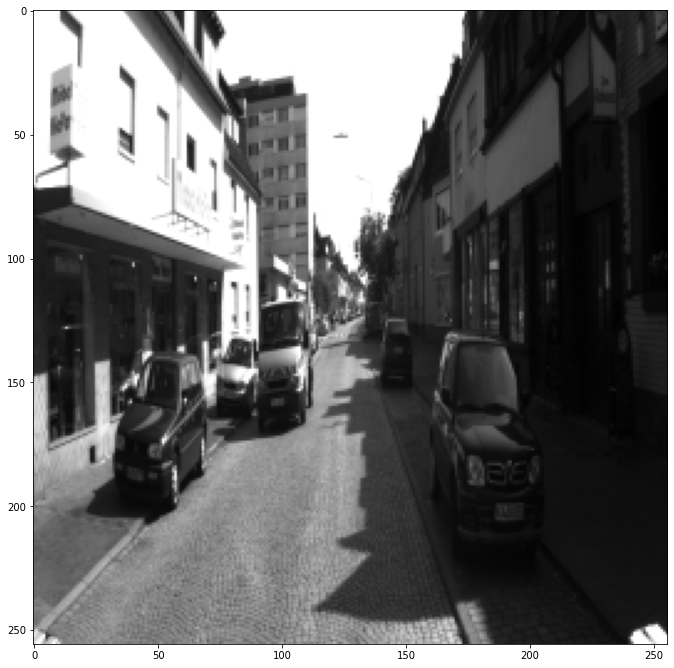

In [ ]:
plt.figure(figsize=[25,25])
plt.subplot(121)
curr_img = np.reshape(Xtrain[0], (256,256))
#curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
Xtrain= Xtrain.reshape(-1, 256,256, 1)
print(Xtrain.shape)
print(tf.__version__)

In [ ]:
# train_X = Xtrain[:20]
# valid_X = Xtrain[20:]
# train_ground = Xtrain[:20]
# valid_ground = Xtrain[20:]
# print(train_X.shape)
# print(valid_X.shape)
# print(train_ground.shape)
# print(valid_ground.shape)


train_X = Xtrain[:420]
valid_X = Xtrain[420:]
train_ground = Xtrain[:22]
valid_ground = Xtrain[22:]
print(train_X.shape)
print(valid_X.shape)
print(train_ground.shape)
print(valid_ground.shape)

(28, 256, 256, 1)
(0, 256, 256, 1)
(22, 256, 256, 1)
(6, 256, 256, 1)


In [ ]:
batch_size = 1
epochs = 150
inChannel = 1
x, y = 256, 256
input_img = Input(shape = ((x, y, inChannel)))
input_img1 = Input(shape = ((x, y, inChannel)))
input_img2 = Input(shape = ((x, y, inChannel)))
input_img3 = Input(shape = ((x, y, inChannel)))
input_img4 = Input(shape = ((x, y, inChannel)))
decoder_input= Input(shape = ((256,256,256)))

In [ ]:


def encoder(input_img,input_img1,input_img2,input_img3,input_img4):
    init = RandomNormal(stddev=0.02)
    merged = Concatenate()([input_img1, input_img2])
    merged = Concatenate()([merged, input_img3])
    merged = Concatenate()([merged, input_img4])
    conv1 = Conv2D(64,7, strides=2,padding='same', kernel_initializer=init)(merged) 
    # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #64 x 132 x 128
    conv1 = BatchNormalization()(conv1)
    pool1 = LeakyReLU(alpha=0.2)(conv1)
    conv2 = Conv2D(128,3, strides=2,padding='same', kernel_initializer=init)(pool1) 
    # pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #32 x 66 x 128
    conv2 = BatchNormalization()(conv2) 
    pool2 = LeakyReLU(alpha=0.2)(conv2)
    conv3 = Conv2D(256,3,strides=2, padding='same', kernel_initializer=init)(pool2)
    # pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #16 x 33 x 256
    conv3 = BatchNormalization()(conv3) 
    pool3 = LeakyReLU(alpha=0.2)(conv3) 
    conv4 = Conv2D(256,3,strides=2,padding='same', kernel_initializer=init)(pool3)
    # pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #16 x 33 x 256
    conv4 = BatchNormalization()(conv4) 
    pool4 = LeakyReLU(alpha=0.2)(conv4)     
    # encod = Model([input_img1,input_img2,input_img3,input_img4],pool3)

    conv7 = Conv2DTranspose(256,3,strides=2, padding='same', kernel_initializer=init)(pool4)  
    # up2 = UpSampling2D((2,2))(conv6) #64 x 132 x 256
    conv7 = BatchNormalization()(conv7) 
    up2 = LeakyReLU(alpha=0.2)(conv7)
    up2 = Concatenate()([up2, pool3 ]) 
    conv8 = Conv2DTranspose(128,3,strides=2, padding='same', kernel_initializer=init)(up2)  
    # up2 = UpSampling2D((2,2))(conv6) #64 x 132 x 256
    conv8 = BatchNormalization()(conv8) 
    up3 = LeakyReLU(alpha=0.2)(conv8)
    up3 = Concatenate()([up3, pool2 ]) 
    conv9 = Conv2DTranspose(64,3,strides=2, padding='same', kernel_initializer=init)(up3)  
    # up2 = UpSampling2D((2,2))(conv6) #64 x 132 x 256
    conv9 = BatchNormalization()(conv9) 
    up4 = LeakyReLU(alpha=0.2)(conv9)
    up4 = Concatenate()([up4, pool1 ]) 
    # conv7 = Conv2D(128, (3, 3), padding='same', kernel_initializer=init)(up2) 
    # conv10 = BatchNormalization()(conv7) 
    # up3 = UpSampling2D((2,2))(conv7) # 128 x 264 x 128
    # up3 = BatchNormalization()(up3) 
    decoded = Conv2DTranspose(1, 7,strides=2,activation='tanh', padding='same', kernel_initializer=init)(up4)
    # decoded = UpSampling2D((2,2))(decoded)
    # decod = Model(decoder_input, decoded)
    decod = Model([input_img1,input_img2,input_img3,input_img4],decoded)
    return decod


In [ ]:
print(input_img)
# ec=encoder(input_img)
auto_encoder = encoder(input_img,input_img1, input_img2,input_img3,input_img4)
auto_encoder.summary()
# encoder = Model([input_img1,input_img2,input_img3,input_img4],ec)
# decode=decoder_old(decoder_input)
# #encoder.summary()
# decode.summary()

Tensor("input_101:0", shape=(?, 256, 256, 1), dtype=float32)
Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_102 (InputLayer)          (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_103 (InputLayer)          (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
concatenate_133 (Concatenate)   (None, 256, 256, 2)  0           input_102[0][0]                  
                                                                 input_103[0][0]                  
__________________________________________________________________________________________________
input_104 (InputLayer)        

In [ ]:
# temp=code([input_img1,input_img2,input_img3,input_img4])
# dec_output=decode(temp)
# auto_encoder=Model([input_img1,input_img2,input_img3,input_img4],dec_output)
opt = Adam(lr=0.0002, beta_1=0.5)
auto_encoder.compile(loss='mean_squared_error', optimizer = opt)

In [ ]:
train_x1=Xtrain[:16]
train_x2=Xtrain[1:17]
train_x3=Xtrain[2:18]
train_x4=Xtrain[3:19]
y_train=Xtrain[4:20]
# # test_x1 =Xtrain[402:406]
# # test_x2 =Xtrain[403:407]
# # test_x3 =Xtrain[404:408]
# # test_x4 =Xtrain[405:409]
# test_x1 =Xtrain[13:17]
# test_x2 =Xtrain[14:18]
# test_x3 =Xtrain[15:19]
# test_x4 =Xtrain[16:20]
# train_x1=Xtrain[:400]
# train_x2=Xtrain[1:401]
# train_x3=Xtrain[2:402]
# train_x4=Xtrain[3:403]
# y_train=Xtrain[4:404]
# train_x1=Xtrain[:300]
# train_x2=Xtrain[1:301]
# train_x3=Xtrain[2:302]
# train_x4=Xtrain[3:303]
# y_train=Xtrain[4:304]
# print(train_x1.shape)
# train_x1=Xtrain[:340]
# train_x11 = Xtrain[40:356]
# train_x2=Xtrain[1:341]
# train_x12 = Xtrain[41:357]
# train_x3=Xtrain[2:342]
# train_x13 = Xtrain[42:358]
# train_x4=Xtrain[3:343]
# train_x14 = Xtrain[43:359]
# y_train=Xtrain[4:344]
# #y_train1 = Xtrain[44:360]
print(train_x1.shape)

(16, 256, 256, 1)


In [ ]:
auto_encoder=load_model('/gdrive/My Drive/Frame_prediction_kitti/unet_input_combined_auto_encoder_500_Train_3.h5')
autoencoder_train = auto_encoder.fit([train_x1,train_x2,train_x3,train_x4], y_train,epochs=epochs,verbose=1)


Epoch 1/150
16/16 [==============================] - 5s 284ms/step - loss: 0.0360
Epoch 2/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0242
Epoch 3/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0332
Epoch 4/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0426
Epoch 5/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0308
Epoch 6/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0231
Epoch 7/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0211
Epoch 8/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0189
Epoch 9/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0173
Epoch 10/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0162
Epoch 11/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0151
Epoch 12/150
16/16 [==============================] - 0s 10ms/step - loss: 0.0140
Epoch 13/150
16/16 [====

In [ ]:
# test_x1 =Xtrain[345:349]
# test_x2 =Xtrain[346:350]
# test_x3 =Xtrain[347:351]
# test_x4 =Xtrain[348:352]

test_x1 =Xtrain[2:6]
test_x2 =Xtrain[3:7]
test_x3 =Xtrain[4:8]
test_x4 =Xtrain[5:9]
#auto_encoder.save('/gdrive/My Drive/Frame_prediction_kitti/unet_input_combined_auto_encoder_1000_Train_3.h5')
pred=auto_encoder.predict([test_x1,test_x2,test_x3,test_x4])

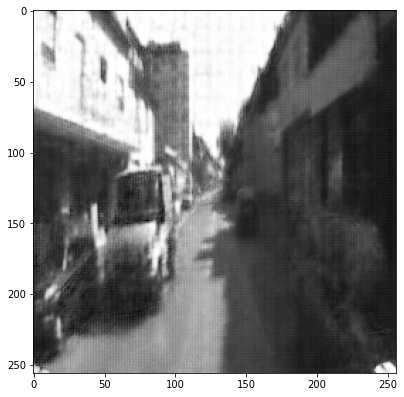

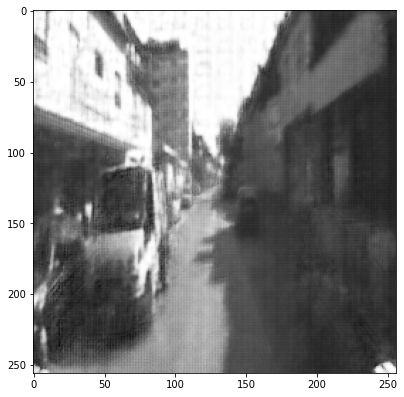

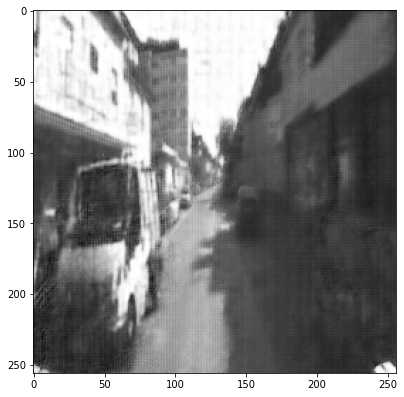

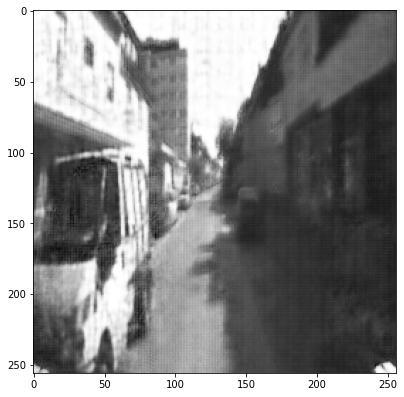

In [ ]:
for i in range(0,4):
    plt.figure(figsize=(100, 200))
    plt.subplot(2,13,1)
    plt.imshow(pred[(i),...,0],cmap='gray')
    plt.show()

In [ ]:
#DISCRIMINATOR 
# input_img_disc = Input(shape = (128, 264, 1))
# def discriminator(input_img_disc):
#     init = RandomNormal(stddev=0.02)
#     conv1 = Conv2D(64, (4, 4),strides=(2,2), activation='relu', padding='same',kernel_initializer=init)(input_img_disc) 
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
#     conv2 = Conv2D(128, (4, 4),strides=(2,2), activation='relu', padding='same',kernel_initializer=init)(pool1) 
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
#     conv3 = Conv2D(256, (4, 4),strides=(2,2), activation='relu', padding='same',kernel_initializer=init)(pool2) 
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
#     conv5=Conv2D(4,(1,1),activation='relu',padding='same',kernel_initializer=init)(pool3)
#     flat=Flatten()(conv5)
#     predi = Dense(1, activation='sigmoid',kernel_initializer=init)(flat)
#     return predi



# def call_disc(input_img_disc):
#   discriminato = Model(input_img_disc, discriminator(input_img_disc))
#   opt = Adam(lr=0.00002, beta_1=0.5)
#   discriminato.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
#   #discriminator.summary()
#   return discriminato
# from keras.layers import Activation
from keras.layers import Activation
def define_discriminator(input_img1,input_img2,input_img3,input_img4,input_img):
	# weight initialization
  init = RandomNormal(stddev=0.02)
  merged = Concatenate()([input_img1, input_img2])
  merged = Concatenate()([merged, input_img3])
  merged = Concatenate()([merged, input_img4])
	# source image input
  # in_src_image = Input(shape=input_img)
	# # target image input
  # in_target_image = Input(shape=input_img)
	# concatenate images channel-wise
  merged = Concatenate()([merged, input_img])
  print(merged)
	# C64
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  # print(d)
	# C128
  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
	# C256
  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
	# C512
  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
	# patch output
  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  # d=Flatten()(d)
  patch_out = Activation('sigmoid')(d)
  # patch_out=Flatten()(patch_out)
  # print(patch_out)
	# define model
  model = Model([input_img1,input_img2,input_img3,input_img4, input_img], patch_out)
	# compile model
  opt = Adam(lr=0.000002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model
 

d_model=define_discriminator(input_img,input_img1,input_img2,input_img3,input_img4)
d_model.summary()

Tensor("concatenate_142/concat:0", shape=(?, 256, 256, 5), dtype=float32)
Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_101 (InputLayer)          (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_102 (InputLayer)          (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
concatenate_139 (Concatenate)   (None, 256, 256, 2)  0           input_101[0][0]                  
                                                                 input_102[0][0]                  
__________________________________________________________________________________________________
input_103 (InputL

In [ ]:

def define_gan(g_model, d_model, input_img,input_img1,input_img2,input_img3,input_img4):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect the source images to the generator input
	gen_out = g_model([input_img1,input_img2,input_img3,input_img4])
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([input_img1,input_img2,input_img3,input_img4,gen_out])
	model = Model([input_img1,input_img2,input_img3,input_img4], [dis_out, gen_out])
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy','mae'], optimizer=opt, loss_weights=[1,100])
	return model


gan_model = define_gan(auto_encoder, d_model,input_img,input_img1,input_img2,input_img3,input_img4)
gan_model.summary()
# def call_gan(g_model,d_model,input_img1,input_img2,input_img3,input_img4):
# 	model=Model([input_img1,input_img2,input_img3,input_img4],define_gan(g_model,d_model,input_img1,input_img2,input_img3,input_img4))
# 	opt = Adam(lr=0.00007, beta_1=0.5)
# 	model.compile(loss='binary_crossentropy', optimizer=opt,loss_weights=[0.5])
# 	print(model.summary)
# 	return model  

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_102 (InputLayer)          (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_103 (InputLayer)          (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_104 (InputLayer)          (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_105 (InputLayer)          (None, 256, 256, 1)  0                                            
___________________________________________________________________________________________

In [ ]:

def generate_real_samples(Xtrain,number, batch_size,n_patch):
  list_real_sample = []
  z1=Xtrain[number:number+batch_size]
  z2=Xtrain[number+1:number+batch_size+1]
  z3=Xtrain[number+2:number+batch_size+2]
  z4=Xtrain[number+3:number+batch_size+3]
  real_sample=Xtrain[number+4:number+4+batch_size]
  # for i in range(number+4,number+batch_size):
  #   list_real_sample.append(Xtrain[i])
  #   print("INININ",list_real_sample.shape)
  # real_sample=np.asarray(list_real_sample)
  print("INN ",real_sample.shape)
  # li=[.95]*len(real_sample)
  # y=np.asarray(li)
  # y = np.ones(len(real_sample))
  y = np.ones((len(real_sample), n_patch, n_patch, 1))
  return [z1,z2,z3,z4,real_sample], y


def generate_fake_samples(g_model, Xtrain,number,batch_size,n_patch):
  z1=Xtrain[number:number+batch_size]
  z2=Xtrain[number+1:number+batch_size+1]
  z3=Xtrain[number+2:number+batch_size+2]
  z4=Xtrain[number+3:number+batch_size+3]
  final_pred = g_model.predict([z1,z2,z3,z4])
  print("Predicted Output for the sequence is ")
  # for i in range(0,4):
  #   plt.figure(figsize=(100, 100))
  #   plt.subplot(2,13,1)
  #   plt.imshow(final_pred[(i),...,0],cmap='gray')
  #   plt.show()
  # li=[.05]*len(final_pred)
  # y=np.asarray(li)
  y = np.zeros((len(final_pred), n_patch, n_patch, 1))
  return final_pred, y

In [ ]:
def train(g_model, d_model, gan_model, Xtrain, n_epochs=50, n_batch=4,n_patch=16):
  bat_per_epo = int(len(Xtrain)/ n_batch)
  half_batch = int(n_batch / 2)
	# manually enumerate epochs
  history = []
  for i in range(n_epochs):
		# enumerate batches over the training set
    print("EPOCH NUMBER ",i)
    for j in range(bat_per_epo):
      number=random.randint(0,15)
      print(number)
			# get randomly selected 'real' samples
      [z1,z2,z3,z4,real_sample],y_real = generate_real_samples(Xtrain,number, n_batch,n_patch)
      print((z2.shape))
      d_loss1 = d_model.train_on_batch([z1,z2,z3,z4,real_sample], y_real)
			# generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, Xtrain,number, n_batch,n_patch)
      # for k in range(0,4):
      #   plt.figure(figsize=(100, 100))
      #   plt.subplot(2,13,1)
      #   plt.imshow(X_fake[(k),...,0],cmap='gray')
      #   plt.show()
      d_loss2 = d_model.train_on_batch([z1,z2,z3,z4, X_fake], y_fake)
      g_loss, _, _ = gan_model.train_on_batch([z1,z2,z3,z4], [y_real, real_sample])
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
      history.append({"D_real":d_loss1,"D_fake":d_loss2})
	# save the generator model
	#g_model.save('cgan_generator.h5')
  return d_model,g_model,gan_model,history

In [ ]:
 number=2
 n_batch=4
#  [z1,z2,z3,z4,real_sample],y_real = generate_real_samples(Xtrain,number, n_batch,16)
 d_history = d_model.fit([z1,z2,z3,z4,real_sample], y_real,epochs=epochs,verbose=1)

/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/150
4/4 [==============================] - 11s 3s/step - loss: 0.6164
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 0.6074
Epoch 3/150
4/4 [==============================] - 0s 18ms/step - loss: 0.5987
Epoch 4/150
4/4 [==============================] - 0s 17ms/step - loss: 0.5904
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 0.5824
Epoch 6/150
4/4 [==============================] - 0s 15ms/step - loss: 0.5746
Epoch 7/150
4/4 [==============================] - 0s 15ms/step - loss: 0.5670
Epoch 8/150
4/4 [==============================] - 0s 16ms/step - loss: 0.5596
Epoch 9/150
4/4 [==============================] - 0s 14ms/step - loss: 0.5523
Epoch 10/150
4/4 [==============================] - 0s 13ms/step - loss: 0.5451
Epoch 11/150
4/4 [==============================] - 0s 13ms/step - loss: 0.5380
Epoch 12/150
4/4 [==============================] - 0s 13ms/step - loss: 0.5310
Epoch 13/150
4/4 [==============================] 

In [ ]:
# d_model=load_model('/gdrive/My Drive/Frame_prediction_kitti/unet_input_combined_discriminator_300_Train3.h5')
# generator=load_model('/gdrive/My Drive/Frame_prediction_kitti/unet_input_combined_generator_300_Train3.h5')
# gan_model=load_model('/gdrive/My Drive/Frame_prediction_kitti/unet_input_combined_gan_300_Train3.h5')
in_src = Input(shape = ((64, 174, 1024)))
# gan_model=define_gan(generator(input_concatenated),call_disc(input_img_disc),input_concatenated)
discriminator,generator,gan_model,history=train(auto_encoder,d_model,gan_model,Xtrain)

EPOCH NUMBER  0
12
INN  (4, 256, 256, 1)
(4, 256, 256, 1)
Predicted Output for the sequence is 


/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/7, d1=0.183, d2=0.779 g=3.983
10
INN  (4, 256, 256, 1)
(4, 256, 256, 1)
Predicted Output for the sequence is 
>1, 2/7, d1=0.168, d2=0.754 g=4.943
4
INN  (4, 256, 256, 1)
(4, 256, 256, 1)
Predicted Output for the sequence is 
>1, 3/7, d1=0.151, d2=0.779 g=6.394
3
INN  (4, 256, 256, 1)
(4, 256, 256, 1)
Predicted Output for the sequence is 
>1, 4/7, d1=0.137, d2=0.790 g=4.664
1
INN  (4, 256, 256, 1)
(4, 256, 256, 1)
Predicted Output for the sequence is 
>1, 5/7, d1=0.130, d2=0.789 g=4.600
12
INN  (4, 256, 256, 1)
(4, 256, 256, 1)
Predicted Output for the sequence is 
>1, 6/7, d1=0.186, d2=0.690 g=5.635
12
INN  (4, 256, 256, 1)
(4, 256, 256, 1)
Predicted Output for the sequence is 
>1, 7/7, d1=0.186, d2=0.673 g=3.975
EPOCH NUMBER  1
9
INN  (4, 256, 256, 1)
(4, 256, 256, 1)
Predicted Output for the sequence is 
>2, 1/7, d1=0.189, d2=0.670 g=3.567
4
INN  (4, 256, 256, 1)
(4, 256, 256, 1)
Predicted Output for the sequence is 
>2, 2/7, d1=0.169, d2=0.708 g=4.642
8
INN  (4, 256, 256, 1)
(

In [ ]:
test_x1 =Xtrain[2:6]
test_x2 =Xtrain[3:7]
test_x3 =Xtrain[4:8]
test_x4 =Xtrain[5:9]
# pred =generator.predict([test_x1,test_x2,test_x3,test_x4])
pred =generator.predict([test_x1,test_x2,test_x3,test_x4])
# discriminator.save('/gdrive/My Drive/Frame_prediction_kitti/unet_input_combined_discriminator_100_Train1_exper.h5')
# generator.save('/gdrive/My Drive/Frame_prediction_kitti/unet_input_combined_generator_100_Train1_exper.h5')
# gan_model.save('/gdrive/My Drive/Frame_prediction_kitti/unet_input_combined_gan_100_Train1_exper.h5')

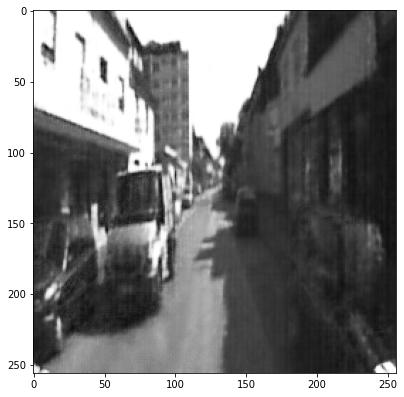

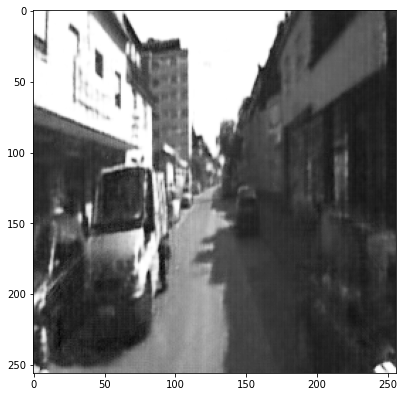

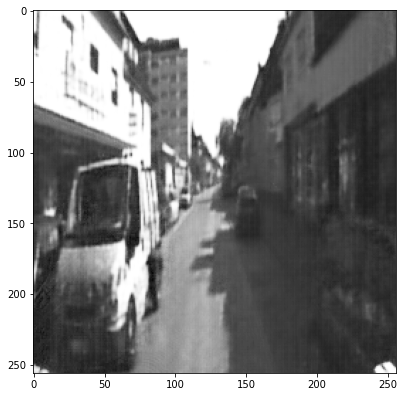

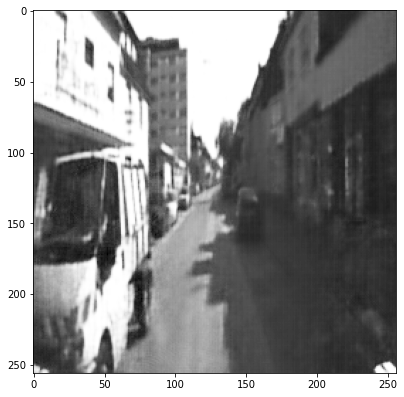

In [ ]:
for i in range(0,4):
    plt.figure(figsize=(100, 100))
    plt.subplot(2,13,1)
    plt.imshow(pred[(i),...,0],cmap='gray')
    plt.show()

In [ ]:
def _plot_loss( history):
        hist = pd.DataFrame(history)
        plt.figure(figsize=(20,5))
        plt.ylim(0.2,0.6)
        plt.title("Graph of loss for 600 iterations of GAN training , learning rate = 0.002 for generator and 0.000002 for discriminator")
        for colnm in hist.columns:
            plt.plot(hist[colnm],label=colnm)
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("iterations")
        plt.show()

In [ ]:
import pandas as pd
# _plot_loss(history)

In [ ]:
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
def compare_images(imageA, imageB, title,X_train):
	# compute the mean squared error and structural similarity
	# index for the images

	# setup the figure
	
	for i in range(4):
		m = mse(imageA[i], imageB[i])
		s = measure.compare_ssim(imageA[i], imageB[i],multichannel=True)
		print("Input sequence is")
		plt.figure(figsize=(80, 60))
		for j in range(i,i+4):
			plt.subplot(2,15,j+1)
			plt.imshow(X_train[j,...,0],cmap='gray')
		plt.show()
		# plt.suptitle("MSE: %.4f, SSIM: %.4f" % (m, s))
	# show first image
		print("Predicted Frame is -")
		plt.figure(figsize=(80, 60))
		plt.subplot(2,13,j+1)
		plt.title("MSE: %.4f, SSIM: %.4f" % (m, s))
		plt.imshow(imageA[i,...,0],cmap='gray')
		plt.show()
	# show the second image
		print("Original Frame is -")
		plt.figure(figsize=(80, 60))
		plt.subplot(2,13,j+1)
		plt.imshow(imageB[i,...,0],cmap='gray')	

	# show the images
		plt.show()

In [ ]:
X_real=Xtrain[6:10]
# pred=pred[:5]
X_train=Xtrain[2:12]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Input sequence is


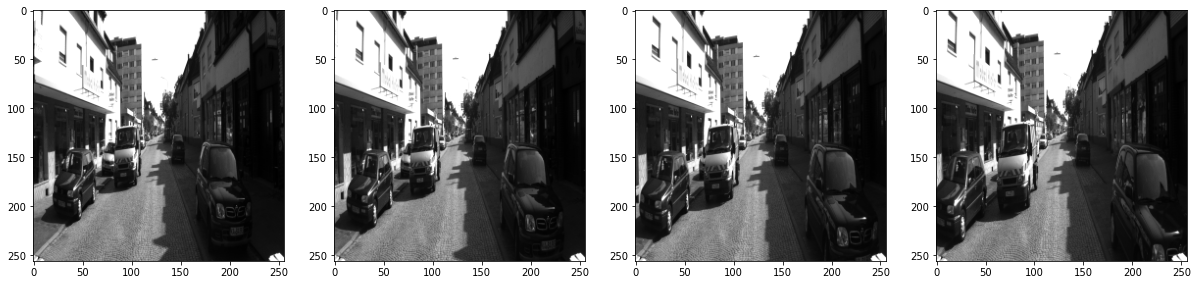

Predicted Frame is -


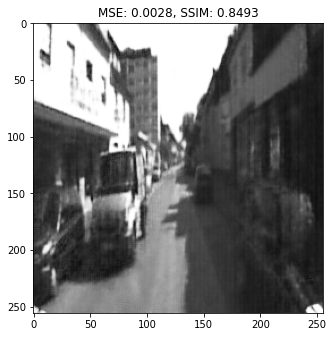

Original Frame is -


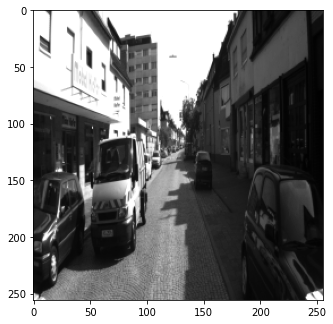

Input sequence is


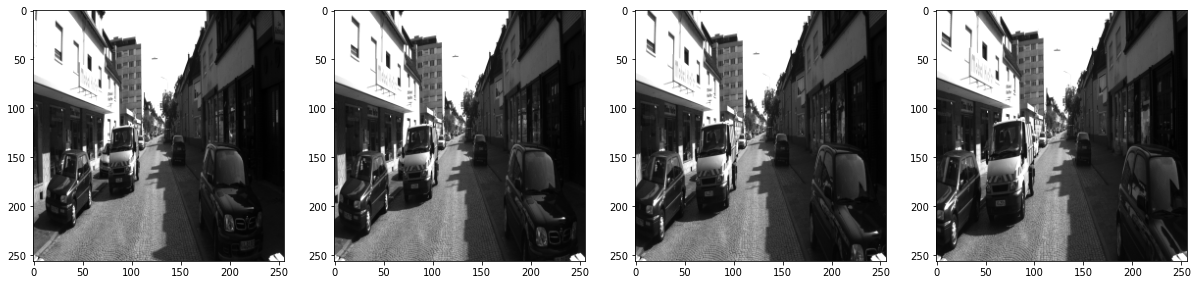

Predicted Frame is -


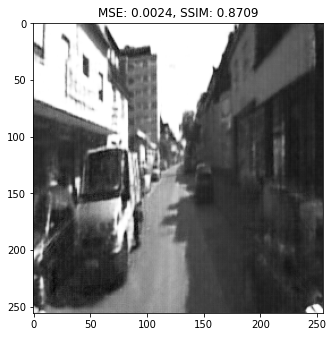

Original Frame is -


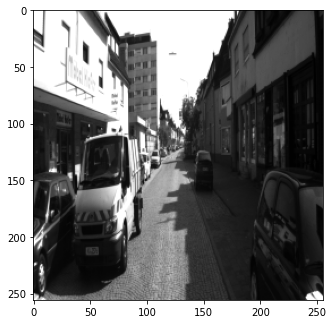

Input sequence is


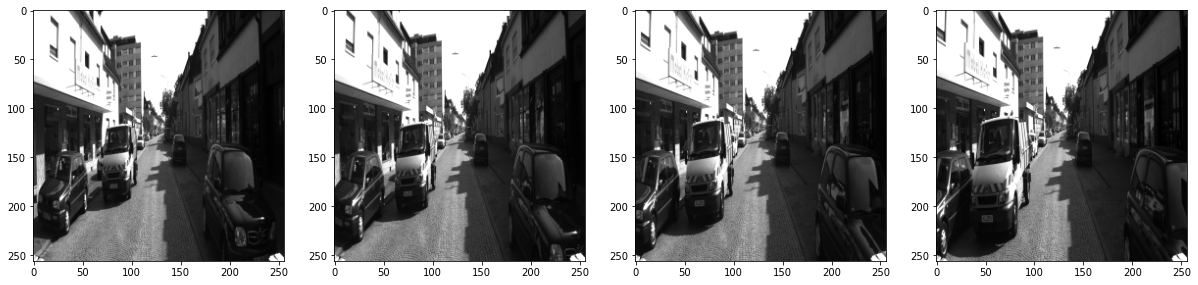

Predicted Frame is -


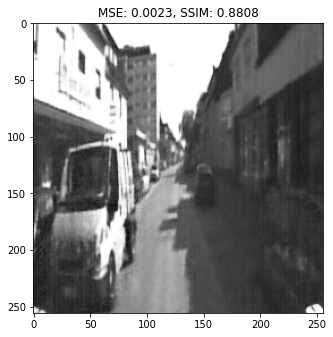

Original Frame is -


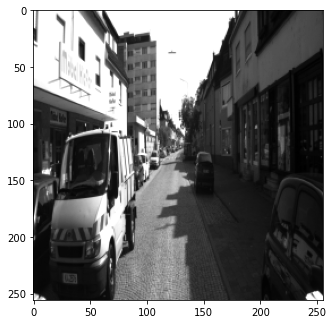

Input sequence is


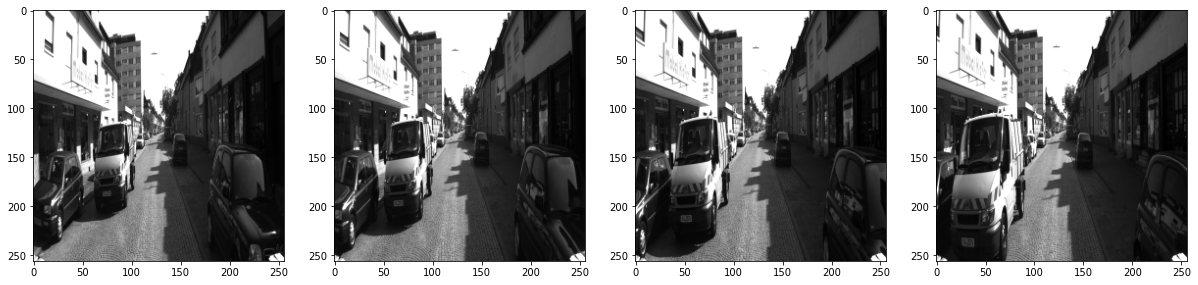

Predicted Frame is -


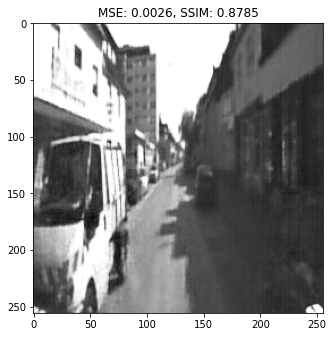

Original Frame is -


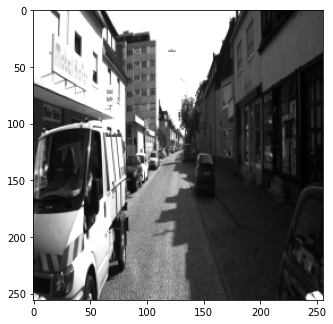

In [ ]:
compare_images(pred,X_real,"hello",X_train)